## Reddit data-set for sarcasm detection

The Sarcasm on Reddit dataset provides comments posted on Reddit labeled as sarcastic (1) or not sarcastic (0).
The task of the project is, given only the parent comment and the Reddit category (subreddit), to predict the probability of a parent comment to receive a sarcastic comment.

Download the dataset and unzip it.

In [1]:
import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files('danofer/sarcasm', unzip=True)

In [2]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression as lg
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib
from matplotlib import pyplot as plt
from scipy.sparse import hstack
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

In [3]:
import tensorflow as tf
import os
from tensorflow import keras

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.3.0


In [4]:
# Importing the Keras libraries and packages
from keras import backend as K
from keras.utils import to_categorical
from keras.layers import Dense, ZeroPadding2D, AveragePooling2D
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import InceptionResNetV2
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [5]:
import spacy
spacy.load('en_core_web_sm')
from spacy.lang.en import English
parser = English()

### Data-set analysis

We import the data and analyze it.

As the creator of the dataset states the Reddit dataset contains 1.3 million Sarcastic comments from the Internet commentary website Reddit and it was generated by scraping comments from Reddit containing the \s (sarcasm) tag. This tag is often used by Redditors to indicate that their comment is in jest and not meant to be taken seriously, and is generally a reliable indicator of sarcastic comment content.

In [6]:
red = pd.read_csv('train-balanced-sarcasm.csv')
red.head(10)

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?
6,0,Trick or treating in general is just weird...,only7inches,AskReddit,1,-1,-1,2016-10,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...
7,0,Blade Mastery+Masamune or GTFO!,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...
8,0,"You don't have to, you have a good build, buy ...",SoupToPots,pcmasterrace,1,-1,-1,2016-10,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...
9,0,I would love to see him at lolla.,chihawks,Lollapalooza,2,-1,-1,2016-11,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...


In [7]:
print(red.shape[0])  # gives number of row count
print(red.shape[1])  # gives number of col count

1010826
10


In [8]:
print(red['parent_comment'][5])
print(red['comment'][5])
print(red['label'][5])

do you find ariana grande sexy ?
I don't pay attention to her, but as long as she's legal I wouldn't kick her out of bed (before she took a load)
0


The analysis will begin by focusing on a small sample of the dataset since as it is possible to observe from the previous command the dataset (not yet pre-processed) contains 1010826 rows, 962295 unique values (as for what concerns the comments' column) and 984286 unique values (for the parent comment section). The difference between the total number of rows of the data frame, that of the comments and the ones of the parent comments implies that there are some nan values. As a matter of fact:

In [9]:
red.isnull().sum() # There are 53 nan values for the comments' column

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [10]:
red = red[red['comment'].notna()]
red.isnull().sum()

label             0
comment           0
author            0
subreddit         0
score             0
ups               0
downs             0
date              0
created_utc       0
parent_comment    0
dtype: int64

In [11]:
red_sample = red.sample(frac = 0.05) ## Since the original dataset is huge, we will work with a small sample of it
print(red_sample.shape[0])  # gives number of row count
print(red_sample.shape[1])  # gives number of col count

50539
10


In [12]:
## Let's check the number of unique values in the label columns: this operation should confirm that we only have two labels:
# 0 = non sarcastic comment
# 1 = sarcastic comment
red_sample['label'].nunique()

2

Based on the information given by its owner the dataset should be balanced, this however an analysis of the distribution of the labels will follow, in order to check whether we need to adjust the class distribution of our dataset using adapting techniques such as oversampling or undersampling.

C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

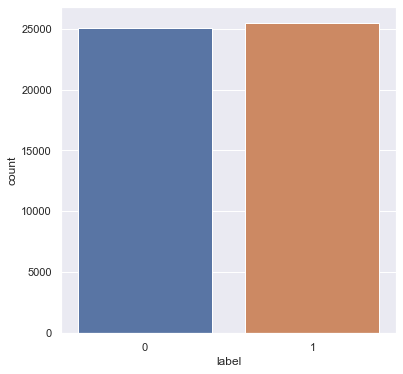

In [13]:
sns.set(rc={'figure.figsize':(6,6)})
sns.countplot(red_sample['label']) # The dataset, or in this case the sample, is confirmed to be balanced

Let's consider one comment to undrstand tokenization, lemmatization, stopwords removal and POS tagging.

In [14]:
example = red['parent_comment'][0]

In [15]:
example

"Yeah, I get that argument. At this point, I'd prefer is she lived in NC as well."

In [16]:
example_comment = red['comment'][0]

In [17]:
example_comment

'NC and NH.'

In [18]:
example_label = red['label'][0]
example_label

0

In [19]:
## Example of SENTENCE tokenization
from nltk.tokenize import sent_tokenize
tokenized_sentence_example = sent_tokenize(example)
print(tokenized_sentence_example)

['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]


In [20]:
## Example of WORD tokenization
from nltk.tokenize import word_tokenize
tokenized_word_example = word_tokenize(example)
print(tokenized_word_example)

['Yeah', ',', 'I', 'get', 'that', 'argument', '.', 'At', 'this', 'point', ',', 'I', "'d", 'prefer', 'is', 'she', 'lived', 'in', 'NC', 'as', 'well', '.']


In [21]:
## Word frequency distribution
from nltk.probability import FreqDist
freqDistrib = FreqDist(tokenized_word_example)
print(freqDistrib)

<FreqDist with 19 samples and 22 outcomes>


In [22]:
freqDistrib.most_common(3)

[(',', 2), ('I', 2), ('.', 2)]

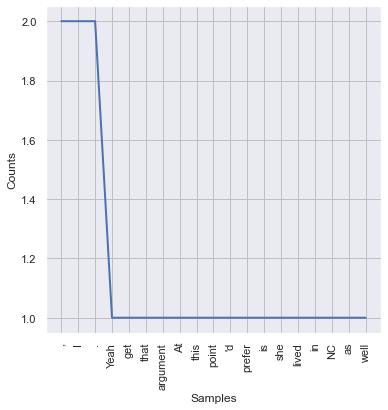

In [23]:
freqDistrib.plot(30,cumulative=False)
plt.show()

In [24]:
stop_words=set(stopwords.words("english"))
print(stop_words)

{'am', 've', 'do', 'didn', 'at', 're', 'doesn', 'both', 'haven', 'some', 'he', 'will', 'your', 'once', 'any', 'so', 'our', 'if', 'between', 'again', 'other', 'had', 'it', "couldn't", "mightn't", 'only', 'her', 'have', 'or', 'but', 'after', "that'll", 'because', 'under', 'during', 'now', "shan't", "you've", 'be', 'o', 'doing', 'for', 'yourself', 'been', 'such', 'below', 'why', 'the', 'each', 'a', 'while', 'you', 'from', 'who', 'how', 'just', 'wasn', 's', 'of', 'shan', 'y', 'needn', "she's", 'll', 'as', 'ma', 'ain', 'those', 'and', 'too', 'has', 'should', 'there', 'his', 'their', 'i', 'not', "mustn't", 'she', "needn't", "should've", 'mustn', "wasn't", 'by', 'shouldn', 'yours', 'm', 'itself', 'were', 'ourselves', 'was', 'very', 'over', 'did', 'hadn', 'before', 'themselves', 'theirs', 'through', 'than', 'd', 'against', 'further', 't', 'with', 'ours', 'hasn', 'won', "don't", "shouldn't", 'can', "haven't", 'into', 'most', 'him', 'its', 'an', "won't", 'are', "you'd", 'then', 'in', 'does', 'is

In [25]:
filteredSentence = []
for w in tokenized_sentence_example:
    if w not in stop_words:
        filteredSentence.append(w)
print("Tokenized Sentence:",tokenized_sentence_example)
print("Filterd Sentence:",filteredSentence)

Tokenized Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]
Filterd Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]


In [26]:
## Stemming
from nltk.stem import PorterStemmer

stemmedWords=[]
for w in filteredSentence:
    stemmedWords.append(PorterStemmer().stem(w))

print("Filtered Sentence:",filteredSentence)
print("Stemmed Sentence:",stemmedWords)

Filtered Sentence: ['Yeah, I get that argument.', "At this point, I'd prefer is she lived in NC as well."]
Stemmed Sentence: ['yeah, i get that argument.', "at this point, i'd prefer is she lived in nc as well."]


In [27]:
## Lemmatization
from nltk.stem.wordnet import WordNetLemmatizer

word = "pretty"
print("Lemmatized Word:",WordNetLemmatizer().lemmatize(word))
print("Stemmed Word:",PorterStemmer().stem(word))

Lemmatized Word: pretty
Stemmed Word: pretti


In [28]:
## POS tagging
nltk.download('averaged_perceptron_tagger')
nltk.pos_tag(tokenized_word_example)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\liry9\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


[('Yeah', 'UH'),
 (',', ','),
 ('I', 'PRP'),
 ('get', 'VBP'),
 ('that', 'DT'),
 ('argument', 'NN'),
 ('.', '.'),
 ('At', 'IN'),
 ('this', 'DT'),
 ('point', 'NN'),
 (',', ','),
 ('I', 'PRP'),
 ("'d", 'MD'),
 ('prefer', 'VB'),
 ('is', 'VBZ'),
 ('she', 'PRP'),
 ('lived', 'VBD'),
 ('in', 'IN'),
 ('NC', 'NNP'),
 ('as', 'RB'),
 ('well', 'RB'),
 ('.', '.')]

## Distribution of sarcastic and non sarcastic comments

In order to compute what is the probability that given only the subreddit and the parent comment, the parent comment is associated with a sarcastic comment it is necessary to drop all the other columns.

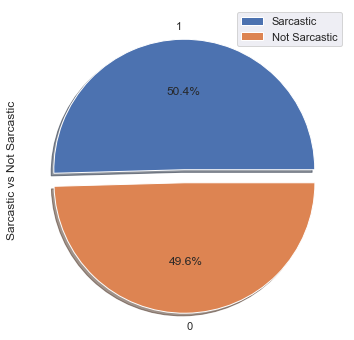

In [29]:
# Pie chart
red_sample["label"].value_counts().plot(kind = 'pie', explode = [0, 0.1], figsize = (6, 6), autopct = '%1.1f%%', shadow = True)
plt.ylabel("Sarcastic vs Not Sarcastic")
plt.legend(["Sarcastic", "Not Sarcastic"])
plt.show()

### Exploratory Analysis

It might be interesting to perform some exploratory analysis on the dataset.

In [30]:
## Number of unique comment author
red_sample['author'].nunique()

42003

In [31]:
## Number of unique subreddit
red_sample['subreddit'].nunique()

4052

In [32]:
# Create a copy of the original dataset
red_copy = red_sample.copy()

Focusing on the column of the comments.

In [33]:
## Group and count the comments by author and label
red_sample.groupby(['author', 'label'],as_index=False).agg({'comment':'count'})

,author,label,comment
0,---Earth---,0,1
1,---Earth---,1,1
2,--Dawn--,0,1
3,--Kai--,1,1
4,--TheLady0fTheLake--,0,1
...,...,...,...
45889,zyxq,0,1
45890,zzMojaveExpress,0,1
45891,zzMojaveExpress,1,1
45892,zzt711,1,1


In [34]:
## Return the number of sarcastic comment per each author
sarcasm_count_by_author = red_sample.groupby('author')['label'].agg([np.sum])
sarcasm_count_by_author

,sum
author,
---Earth---,1
--Dawn--,0
--Kai--,1
--TheLady0fTheLake--,0
--liveitup,1
...,...
zynasis,1
zyxq,0
zzMojaveExpress,1


In [35]:
## Group and count the comments by author
comment_count_by_author = red_sample.groupby(['author'],as_index=False).agg({'comment':'count'})
comment_count_by_author

,author,comment
0,---Earth---,2
1,--Dawn--,1
2,--Kai--,1
3,--TheLady0fTheLake--,1
4,--liveitup,1
...,...,...
41998,zynasis,1
41999,zyxq,1
42000,zzMojaveExpress,2
42001,zzt711,1


In [36]:
comment_sum_up = pd.merge(sarcasm_count_by_author, comment_count_by_author, on='author')
comment_sum_up

,author,sum,comment
0,---Earth---,1,2
1,--Dawn--,0,1
2,--Kai--,1,1
3,--TheLady0fTheLake--,0,1
4,--liveitup,1,1
...,...,...,...
41998,zynasis,1,1
41999,zyxq,0,1
42000,zzMojaveExpress,1,2
42001,zzt711,1,1


In [37]:
comment_sum_up['percentage of sarcastic comments'] = comment_sum_up['sum']/comment_sum_up['comment']
comment_sum_up

,author,sum,comment,percentage of sarcastic comments
0,---Earth---,1,2,0.5
1,--Dawn--,0,1,0.0
2,--Kai--,1,1,1.0
3,--TheLady0fTheLake--,0,1,0.0
4,--liveitup,1,1,1.0
...,...,...,...,...
41998,zynasis,1,1,1.0
41999,zyxq,0,1,0.0
42000,zzMojaveExpress,1,2,0.5
42001,zzt711,1,1,1.0


In [38]:
## Most sarcastic author:
print("The most sarastic author is: %15s" % (comment_count_by_author['author'].loc[comment_count_by_author['comment'].idxmax()]))

The most sarastic author is:     Biffingston


Some further analysis

In [39]:
## Group and count the comments by author and label
red_sample.groupby(['subreddit', 'label'],as_index=False).agg({'comment':'count'})

,subreddit,label,comment
0,100thieves,1,1
1,10cloverfieldlane,0,1
2,10cloverfieldlane,1,1
3,1200isplenty,1,1
4,1200isplentyketo,0,1
...,...,...,...
5706,zelda,0,4
5707,zelda,1,5
5708,zootopia,0,1
5709,zootopia,1,3


In [40]:
## Return the number of sarcastic comment per each subreddit
sarcasm_count_by_subreddit = red_sample.groupby('subreddit')['label'].agg([np.sum])
sarcasm_count_by_subreddit

,sum
subreddit,
100thieves,1
10cloverfieldlane,1
1200isplenty,1
1200isplentyketo,0
125R,0
...,...
yugioh,21
yuruyuri,0
zelda,5


In [41]:
## Group and count the comments by author
comment_count_by_subreddit = red_sample.groupby(['subreddit'],as_index=False).agg({'comment':'count'})
comment_count_by_subreddit

,subreddit,comment
0,100thieves,1
1,10cloverfieldlane,2
2,1200isplenty,1
3,1200isplentyketo,1
4,125R,1
...,...,...
4047,yugioh,40
4048,yuruyuri,1
4049,zelda,9
4050,zootopia,4


In [42]:
subreddit_comment_sum_up = pd.merge(sarcasm_count_by_subreddit, comment_count_by_subreddit, on='subreddit')
subreddit_comment_sum_up

,subreddit,sum,comment
0,100thieves,1,1
1,10cloverfieldlane,1,2
2,1200isplenty,1,1
3,1200isplentyketo,0,1
4,125R,0,1
...,...,...,...
4047,yugioh,21,40
4048,yuruyuri,0,1
4049,zelda,5,9
4050,zootopia,3,4


In [43]:
subreddit_comment_sum_up['percentage of sarcastic comments'] = subreddit_comment_sum_up['sum']/subreddit_comment_sum_up['comment']
subreddit_comment_sum_up

,subreddit,sum,comment,percentage of sarcastic comments
0,100thieves,1,1,1.000000
1,10cloverfieldlane,1,2,0.500000
2,1200isplenty,1,1,1.000000
3,1200isplentyketo,0,1,0.000000
4,125R,0,1,0.000000
...,...,...,...,...
4047,yugioh,21,40,0.525000
4048,yuruyuri,0,1,0.000000
4049,zelda,5,9,0.555556
4050,zootopia,3,4,0.750000


In [44]:
## Most sarcastic subreddit
print("The most sarastic subreddit is: %15s" % (comment_count_by_subreddit['subreddit'].loc[comment_count_by_subreddit['comment'].idxmax()]))

The most sarastic subreddit is:       AskReddit


In [45]:
subreddits = red_sample['subreddit'].value_counts()

In [46]:
pd.DataFrame(subreddits)

,subreddit
AskReddit,3368
politics,2010
worldnews,1351
leagueoflegends,998
pcmasterrace,977
...,...
UnsolicitedRedesigns,1
Catacombs,1
Handrails,1
girls_smiling,1


In [47]:
top_ten = subreddits.head(10)
top_ten = pd.DataFrame(top_ten)

In [48]:
top_ten['sub'] = top_ten.index

In [49]:
top_ten

,subreddit,sub
AskReddit,3368,AskReddit
politics,2010,politics
worldnews,1351,worldnews
leagueoflegends,998,leagueoflegends
pcmasterrace,977,pcmasterrace
funny,911,funny
news,829,news
pics,813,pics
nfl,737,nfl
GlobalOffensive,687,GlobalOffensive


In [50]:
top_ten = top_ten.reset_index(drop=True)
top_ten

,subreddit,sub
0,3368,AskReddit
1,2010,politics
2,1351,worldnews
3,998,leagueoflegends
4,977,pcmasterrace
5,911,funny
6,829,news
7,813,pics
8,737,nfl
9,687,GlobalOffensive


In [51]:
df = red_sample[red_sample.set_index(['subreddit']).index.isin(top_ten.set_index(['sub']).index)]
df = pd.DataFrame(df)

In [52]:
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
983239,1,"Wait, why the Ravens flair?",Flipper3,nfl,5,5,0,2013-03,2013-03-22 09:09:43,You have no idea. Can't wait for draft day.
652298,1,vaynespotter,NilsiaMINE,leagueoflegends,1,1,0,2015-08,2015-08-10 10:20:45,What do you call a vanye tryhard?
990099,1,Thomas Paine was a got-dayum socialist.,KRATOSBRAH,politics,1,1,0,2012-07,2012-07-27 05:55:07,"Thomas Paine on 'you didn't build that' ""Perso..."
637431,0,He cant even say what kind of knife he flippin...,tomjoads,news,2,2,0,2015-05,2015-05-05 22:22:12,Where is the self-defense lawyer incorrect? Do...
379635,1,"Yeah, right wing revolutionaries is what you w...",Schtekarn,worldnews,-21,-21,0,2016-01,2016-01-20 07:53:05,Vigilante. What they need is revolutionary.


In [53]:
#df.loc[df.label == '1', df.subreddit == 'AskReddit'].count()
print(df[(df['label']==1) & (df['subreddit']=='AskReddit')].count())
print(df[(df['label']==0) & (df['subreddit']=='AskReddit')].count())

label             1375
comment           1375
author            1375
subreddit         1375
score             1375
ups               1375
downs             1375
date              1375
created_utc       1375
parent_comment    1375
dtype: int64
label             1993
comment           1993
author            1993
subreddit         1993
score             1993
ups               1993
downs             1993
date              1993
created_utc       1993
parent_comment    1993
dtype: int64


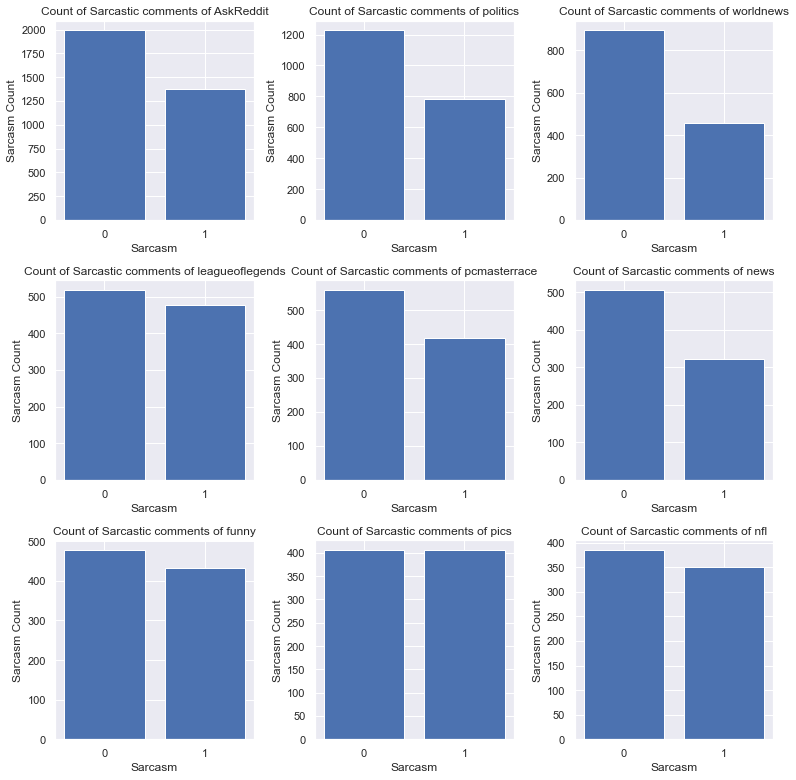

In [56]:
def plot_sub_sentiment(sub):
    dataFrame=df[df['subreddit']==sub]
    count=dataFrame['label'].value_counts()
    Index = [1,2]
    plt.bar(Index,count)
    plt.xticks(Index,['0','1'])
    plt.ylabel('Sarcasm Count')
    plt.xlabel('Sarcasm')
    plt.title('Count of Sarcastic comments of '+sub)
    plt.tight_layout()

plt.figure(1,figsize=(11, 11))
plt.subplot(331)
plot_sub_sentiment('AskReddit')
plt.subplot(332)
plot_sub_sentiment('politics')
plt.subplot(333)
plot_sub_sentiment('worldnews')
plt.subplot(334)
plot_sub_sentiment('leagueoflegends')
plt.subplot(335)
plot_sub_sentiment('pcmasterrace')
plt.subplot(337)
plot_sub_sentiment('funny')
plt.subplot(336)
plot_sub_sentiment('news')
plt.subplot(338)
plot_sub_sentiment('pics')
plt.subplot(339)
plot_sub_sentiment('nfl')

#plt.savefig('C:/Users/liry9/Desktop/Text Mining and Sentiment Analysis/Project/images/sarcasm_count_per_subreddit.pdf')

C:\Users\liry9\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


[Text(0.5, 1.0, 'Sarcastic comments for "GlobalOffensive"')]

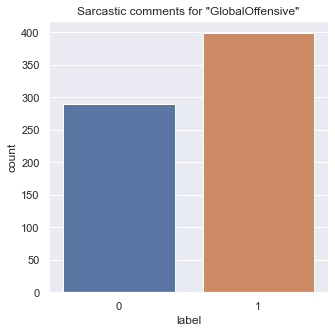

In [57]:
df_leagueoflegends = red_sample[red_sample['subreddit']==top_ten['sub'][9]]
sns.set(rc={'figure.figsize':(5,5)})
sns.countplot(df_leagueoflegends['label']).set(title = 'Sarcastic comments for "GlobalOffensive"')

Let's print out the highest and the lowest scores first and then the corresponding comment and parent comment.

In [58]:
print("The minimum score assigned to a comment is %d, while the highest one is %d" % (red_sample['score'].min(), red_sample['score'].max()))

The minimum score assigned to a comment is -507, while the highest one is 9070


In [59]:
print('The Parent Comment of the comment with the highest score is:\n',red_sample['parent_comment'].loc[red_sample['score'].idxmax()])
print('\n The Comment with the highest score is:\n',red_sample['comment'].loc[red_sample['score'].idxmax()])
if red_sample['label'].loc[red_sample['score'].idxmax()]==1:
    print('\n sarcastic')
else:
    print('\n not sarcastic')

The Parent Comment of the comment with the highest score is:
 China Tells Trump That Climate Change Is No Hoax It Invented

 The Comment with the highest score is:
 That's exactly what a country who made up a hoax about climate change would say!

 sarcastic


In [ ]:
red_sample.loc[red_sample['score'].idxmax()]

In [60]:
## Lowest score comment and its parent comment
print('The Parent Comment of the comment with the lowest score is:\n',red_sample['parent_comment'].loc[red_sample['score'].idxmin()])
print('\n The Comment with the lowest score is:\n',red_sample['comment'].loc[red_sample['score'].idxmin()])
if red_sample['label'].loc[red_sample['score'].idxmin()]==1:
    print('\n sarcastic')
else:
    print('\n non sarcastic')

The Parent Comment of the comment with the lowest score is:
 She did the happy dance! Thats how you know shes happy :)

 The Comment with the lowest score is:
 yes...the smiling is irrelevant when trying to tell if she is happy

 sarcastic


In [61]:
red_sample.loc[red_sample['score'].idxmin()]

label                                                             1
comment           yes...the smiling is irrelevant when trying to...
author                                                     Grippler
subreddit                                                       aww
score                                                          -507
ups                                                            -507
downs                                                             0
date                                                        2016-07
created_utc                                     2016-07-16 14:33:06
parent_comment    She did the happy dance! Thats how you know sh...
Name: 305117, dtype: object

Analysis on the scores

In [62]:
# Mean and STD of Score Rating
mean = red_sample['score'].mean()
std = red_sample['score'].std()
print(mean, std)

6.805239517996003 56.49878009912548


## Text analysis

In [63]:
list(red_sample.columns)

['label',
 'comment',
 'author',
 'subreddit',
 'score',
 'ups',
 'downs',
 'date',
 'created_utc',
 'parent_comment']

In [64]:
red_copy.drop(['comment', 'author', 'score', 'ups', 'downs', 'date', 'created_utc'], axis=1, inplace=True)
red_copy.head(10)

,label,subreddit,parent_comment
352577,1,hillaryclinton,"NYT: Donald Trump, Courting Vital Bloc, Is to ..."
718056,1,nba,OKAY REDDIT DONT FUCK THIS TRIPLE DOUBLE UP PL...
255224,0,PuzzleAndDragons,Jammer Meta is blasphemy.
983239,1,nfl,You have no idea. Can't wait for draft day.
498820,0,MapPorn,They have plenty of forests in the mountains
652298,1,leagueoflegends,What do you call a vanye tryhard?
952521,0,Feminism,Are you saying she deserved the threats?
802460,1,Anarcho_Capitalism,"What is it about Bitcoin, exactly, that makes ..."
858402,1,LearnJapanese,"Working overtime on this thread, Aurigarion?"
384450,1,TrueReddit,"Tariffs. Simple, effective, tried and true for..."


In [65]:
# Find the number of characters for each string in the red_sample dataset
red_copy['char'] = red_copy['parent_comment'].str.len()
red_copy.head()

,label,subreddit,parent_comment,char
352577,1,hillaryclinton,"NYT: Donald Trump, Courting Vital Bloc, Is to ...",70
718056,1,nba,OKAY REDDIT DONT FUCK THIS TRIPLE DOUBLE UP PL...,50
255224,0,PuzzleAndDragons,Jammer Meta is blasphemy.,25
983239,1,nfl,You have no idea. Can't wait for draft day.,43
498820,0,MapPorn,They have plenty of forests in the mountains,44


In [66]:
def plotDistr(var):
    plt.hist(red_copy[var][red_copy['label']==0], density=True, label='Not Sarcastic')
    plt.hist(red_copy[var][red_copy['label']==1], density=True, label='Sarcastic')
    plt.legend()
    plt.show()

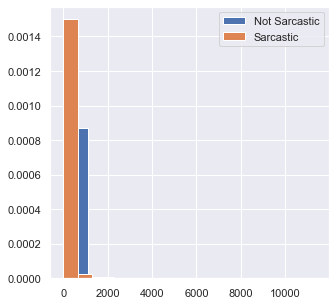

In [67]:
plotDistr('char')

In [68]:
# Number of punctuation symbols
red_copy['punct'] = red_copy['parent_comment'].str.findall(r'[^a-zA-Z\d\s:]').str.len()
red_copy.head()

,label,subreddit,parent_comment,char,punct
352577,1,hillaryclinton,"NYT: Donald Trump, Courting Vital Bloc, Is to ...",70,2
718056,1,nba,OKAY REDDIT DONT FUCK THIS TRIPLE DOUBLE UP PL...,50,0
255224,0,PuzzleAndDragons,Jammer Meta is blasphemy.,25,1
983239,1,nfl,You have no idea. Can't wait for draft day.,43,3
498820,0,MapPorn,They have plenty of forests in the mountains,44,0


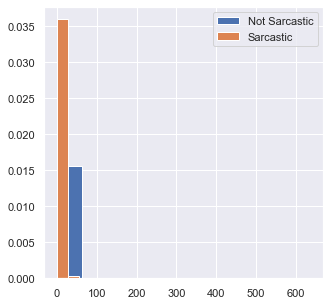

In [69]:
plotDistr('punct')

In [70]:
# Find the number of tokens for each string in the red_sample dataset
red_copy['tokens'] = red_copy['parent_comment'].str.split().str.len()
red_copy.head()

,label,subreddit,parent_comment,char,punct,tokens
352577,1,hillaryclinton,"NYT: Donald Trump, Courting Vital Bloc, Is to ...",70,2,12
718056,1,nba,OKAY REDDIT DONT FUCK THIS TRIPLE DOUBLE UP PL...,50,0,9
255224,0,PuzzleAndDragons,Jammer Meta is blasphemy.,25,1,4
983239,1,nfl,You have no idea. Can't wait for draft day.,43,3,9
498820,0,MapPorn,They have plenty of forests in the mountains,44,0,8


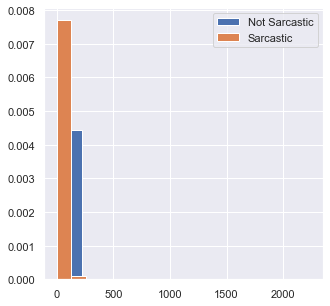

In [71]:
plotDistr('tokens')

In [72]:
# Cleaning the text of the parents' comments
stemmer = SnowballStemmer("english")

def cleanText(x):
    words = [stemmer.stem(word) for word in nltk.word_tokenize(x.lower()) if word.isalpha() and word not in stopwords.words("english")]
    return " ".join(words)

In [73]:
from timeit import default_timer as timer

# get the starting time
startTime = timer()

red_copy["clean"] = red_copy["parent_comment"].apply(cleanText)
red_copy.head()
endTime = timer()

In [74]:
# Get the time needed for stemming all the parent comments and return the cleared texts
print("Time needed to clear the comments is: {} minutes and {:.1f} seconds".format((endTime - startTime)//60, (endTime - startTime)%60))

Time needed to clear the comments is: 3.0 minutes and 57.6 seconds


## Wordcloud

WordCloud is a technique to show which words are the most frequent among the given text.
We start with only one comment:

In [75]:
red_copy.reset_index(inplace=True)
red_copy.drop(['index'], axis=1, inplace=True)
red_copy.head()

,label,subreddit,parent_comment,char,punct,tokens,clean
0,1,hillaryclinton,"NYT: Donald Trump, Courting Vital Bloc, Is to ...",70,2,12,nyt donald trump court vital bloc speak christ...
1,1,nba,OKAY REDDIT DONT FUCK THIS TRIPLE DOUBLE UP PL...,50,0,9,okay reddit dont fuck tripl doubl pleas
2,0,PuzzleAndDragons,Jammer Meta is blasphemy.,25,1,4,jammer meta blasphemi
3,1,nfl,You have no idea. Can't wait for draft day.,43,3,9,idea ca wait draft day
4,0,MapPorn,They have plenty of forests in the mountains,44,0,8,plenti forest mountain


In [76]:
red_copy.rename(columns={'parent_comment':'parent'}, inplace=True)
red_copy.head()

,label,subreddit,parent,char,punct,tokens,clean
0,1,hillaryclinton,"NYT: Donald Trump, Courting Vital Bloc, Is to ...",70,2,12,nyt donald trump court vital bloc speak christ...
1,1,nba,OKAY REDDIT DONT FUCK THIS TRIPLE DOUBLE UP PL...,50,0,9,okay reddit dont fuck tripl doubl pleas
2,0,PuzzleAndDragons,Jammer Meta is blasphemy.,25,1,4,jammer meta blasphemi
3,1,nfl,You have no idea. Can't wait for draft day.,43,3,9,idea ca wait draft day
4,0,MapPorn,They have plenty of forests in the mountains,44,0,8,plenti forest mountain


NYT: Donald Trump, Courting Vital Bloc, Is to Speak at Christian Forum


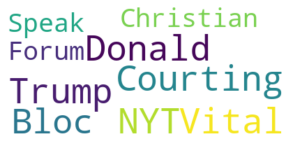

In [77]:
# Start with the first parent comment:
from wordcloud import WordCloud
parent = red_copy.parent[0]
print(parent)

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(parent)

# Display the generated image:
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Wordcloud on all the parent comments:

In [78]:
# Word cloud
def myWordCloud(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_copy['parent'][red_copy["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

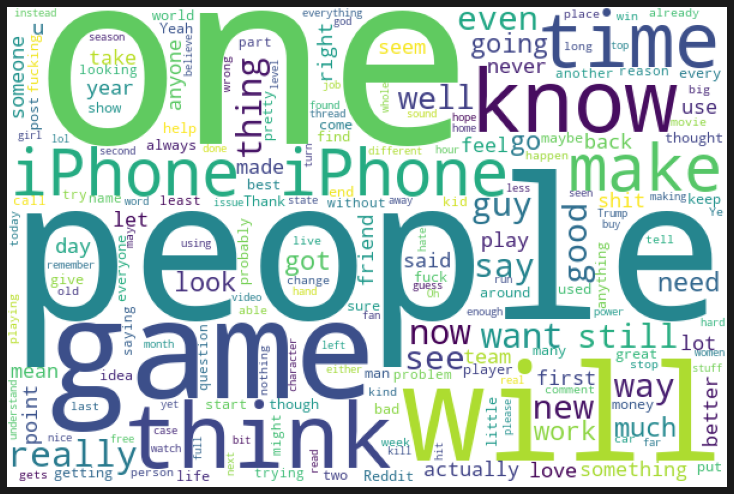

In [79]:
## Wordcloud for Non sarcastic comments
myWordCloud(0)

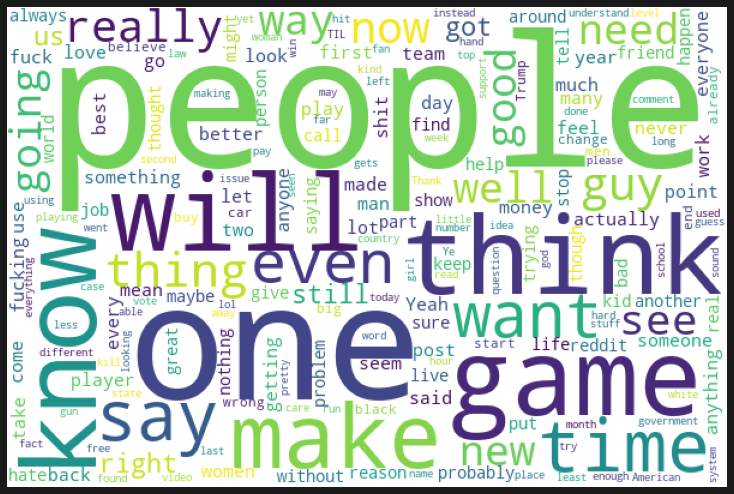

In [80]:
## Wordcloud for Sarcastic comments
myWordCloud(1)

Wordcloud with the cleaned version of the parent comments:

In [81]:
# Word cloud
def myWordCloudCleaned(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_copy['clean'][red_copy["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

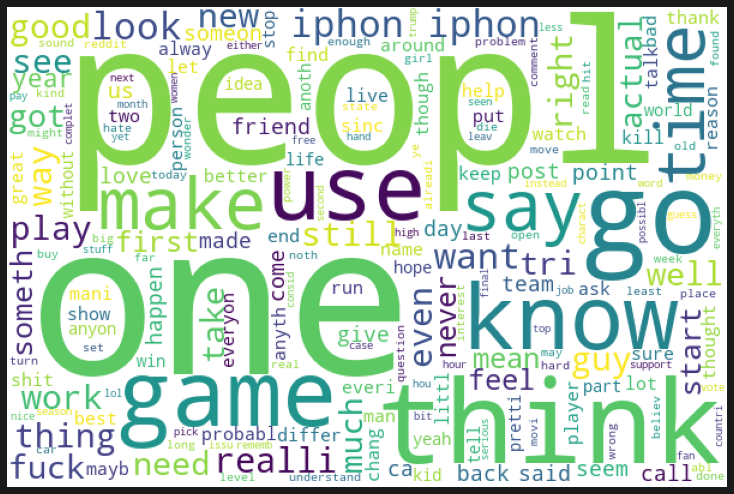

In [82]:
## Wordcloud for Non sarcastic comments
myWordCloudCleaned(0)

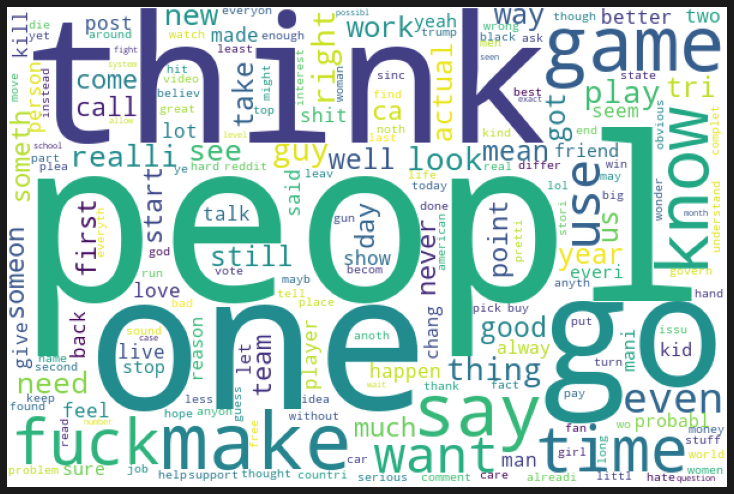

In [83]:
## Wordcloud for Sarcastic comments
myWordCloudCleaned(1)

## Split into train, test and validation set

In [84]:
## Let's check the number of unique values in the subreddit columns
red_sample['subreddit'].nunique()

4052

In [85]:
X = red_copy[['clean','subreddit']]
y = red_copy['label']

In [86]:
X_train, red_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=28)

In [87]:
red_train, red_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=28)

In [88]:
print(red_train.shape)
print(red_val.shape)
print(red_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(32344, 2)
(8087, 2)
(10108, 2)
(32344,)
(8087,)
(10108,)


In [89]:
red_train.head()

,clean,subreddit
20051,recent got dmg silver month half time play dot...,GlobalOffensive
12971,fine old gandi pc seem way npc tast,rpg
41837,happen anim discov god,AskReddit
19748,hardest video game ever play,AskReddit
15527,yeah never quit understand sub like pick histo...,Warthunder


In [90]:
red_val.head()

,clean,subreddit
42280,leav clan save life,ClashOfClans
45359,,gaming
34031,propos vs start cert esf acquisit timer use ma...,Planetside
33395,well mean heroin addict open everyon work incl...,ImGoingToHellForThis
29704,exact isnt even clever realli disappoint c amp h,comics


### TF-IDF on cleaned parent comments

TF-IDF focusing on the parent comments from which we have removed the punctuation and on which we have performed stemmization. We'll have separate Tf-Idf vectorizers for comments and for subreddits.

In [91]:
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import TfidfVectorizer

In [92]:
parent_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=50000, min_df=3)
subreddits_vectorizer = TfidfVectorizer(ngram_range=(1, 1))

In [93]:
clean_train = parent_vectorizer.fit_transform(red_train['clean'])
clean_valid = parent_vectorizer.transform(red_val['clean'])
clean_test = parent_vectorizer.transform(red_test['clean'])

In [94]:
subred_train = subreddits_vectorizer.fit_transform(red_train['subreddit'])
subred_valid = subreddits_vectorizer.transform(red_val['subreddit'])
subred_test = subreddits_vectorizer.transform(red_test['subreddit'])

In [95]:
reddit_train = hstack([clean_train, subred_train])
reddit_valid = hstack([clean_valid, subred_valid])
reddit_test = hstack([clean_test, subred_test])

### Naive Bayes

In [96]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.manifold import TSNE
NB = MultinomialNB()
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

In [97]:
naive_bayes = NB.fit(reddit_train, y_train)

In [98]:
naiveBayes_predict = NB.predict(reddit_test)

In [99]:
metrics.accuracy_score(y_test, naiveBayes_predict)

0.5713296398891967

### Logistic Regression

In [100]:
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)

In [101]:
## Fit the model
logit.fit(reddit_train, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.9s finished


LogisticRegression(C=1, n_jobs=4, random_state=17, verbose=1)

In [102]:
from sklearn.metrics import roc_auc_score, confusion_matrix
roc_auc_score(y_test, logit.predict_proba(reddit_test)[:,1])

0.5928870473908414

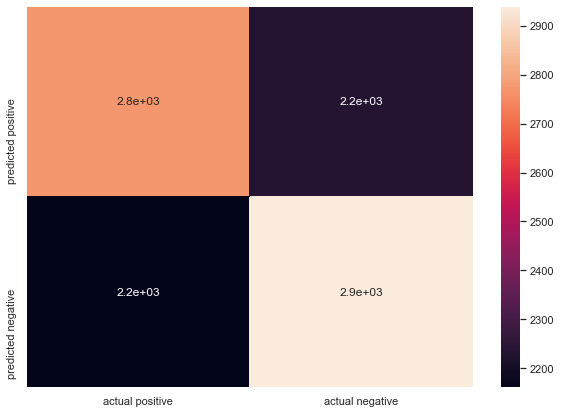

In [103]:
conf_mat = pd.DataFrame(confusion_matrix(y_test, logit.predict(reddit_test)), index = ['predicted positive', 'predicted negative'],
                  columns = ['actual positive', 'actual negative'])
plt.figure(figsize = (10,7))
sns.heatmap(conf_mat, annot=True)
plt.show()

### Random Forest

In [104]:
random_forest = RandomForestClassifier(max_depth=10, max_features=10)
random_forest.fit(reddit_train, y_train)

RandomForestClassifier(max_depth=10, max_features=10)

In [105]:
randomForest_predict = random_forest.predict(reddit_test)

In [106]:
metrics.accuracy_score(y_test, randomForest_predict)

0.5066284131381085

### Cross Validation

In [107]:
X = red_copy[['clean','subreddit']]
y = red_copy['label']

In [108]:
X_train, X_test, y_train2, y_test2 = train_test_split(X, y, test_size=0.20, random_state=28)

In [109]:
X_clean = X_train['clean']
X_subreddit = X_train['subreddit']

In [110]:
train_clean = parent_vectorizer.fit_transform(X_clean)
train_subreddit = subreddits_vectorizer.fit_transform(X_subreddit)

In [111]:
training = hstack([train_clean, train_subreddit])

In [112]:
from sklearn.model_selection import ShuffleSplit, cross_val_score

#### Naive Bayes

In [113]:
NB_cv = cross_val_score(NB, training, y_train2, n_jobs = -1)
NB_cv

array([0.56992704, 0.57296562, 0.56430868, 0.5722236 , 0.57469701])

#### Logistic regression

In [116]:
logit_cv = cross_val_score(logit, training, y_train2, n_jobs = -1)
logit_cv

array([0.5678249 , 0.56195894, 0.56406134, 0.56702943, 0.56690576])

#### Random Forest

In [ ]:
random_forest2 = RandomForestClassifier(max_depth=10, max_features=10)

In [160]:
rf_cv = cross_val_score(random_forest2, training, y_train2, n_jobs = -1)

In [161]:
rf_cv

array([0.50735749, 0.50655454, 0.51100668, 0.51211971, 0.50704922])

## Alternative 2

Adding the subreddit to the comment and therefore conduct the analysis on the combination of the two: since the subreddits are not classified as stopwords when parsing the comments they should not be removed, thus appearing in the cleaned version of the comments.

In [117]:
red_copy.head()

,label,subreddit,parent,char,punct,tokens,clean
0,1,hillaryclinton,"NYT: Donald Trump, Courting Vital Bloc, Is to ...",70,2,12,nyt donald trump court vital bloc speak christ...
1,1,nba,OKAY REDDIT DONT FUCK THIS TRIPLE DOUBLE UP PL...,50,0,9,okay reddit dont fuck tripl doubl pleas
2,0,PuzzleAndDragons,Jammer Meta is blasphemy.,25,1,4,jammer meta blasphemi
3,1,nfl,You have no idea. Can't wait for draft day.,43,3,9,idea ca wait draft day
4,0,MapPorn,They have plenty of forests in the mountains,44,0,8,plenti forest mountain


In [118]:
red_copy['text'] = red_copy.clean + " " + red_copy.subreddit
red_copy.head()

,label,subreddit,parent,char,punct,tokens,clean,text
0,1,hillaryclinton,"NYT: Donald Trump, Courting Vital Bloc, Is to ...",70,2,12,nyt donald trump court vital bloc speak christ...,nyt donald trump court vital bloc speak christ...
1,1,nba,OKAY REDDIT DONT FUCK THIS TRIPLE DOUBLE UP PL...,50,0,9,okay reddit dont fuck tripl doubl pleas,okay reddit dont fuck tripl doubl pleas nba
2,0,PuzzleAndDragons,Jammer Meta is blasphemy.,25,1,4,jammer meta blasphemi,jammer meta blasphemi PuzzleAndDragons
3,1,nfl,You have no idea. Can't wait for draft day.,43,3,9,idea ca wait draft day,idea ca wait draft day nfl
4,0,MapPorn,They have plenty of forests in the mountains,44,0,8,plenti forest mountain,plenti forest mountain MapPorn


In [119]:
def myWordCloudText(label):
    reddit_wordcloud = WordCloud(width=600, height=400, background_color="white").generate(" ".join(red_copy['text'][red_copy["label"]==label]))
    plt.figure(figsize=(10,8), facecolor='k')
    plt.imshow(reddit_wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()

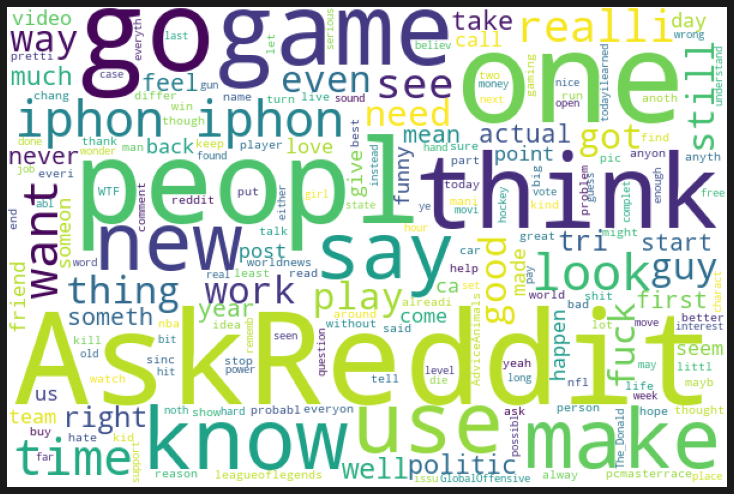

In [120]:
## Wordcloud for Non sarcastic comments
myWordCloudText(0)

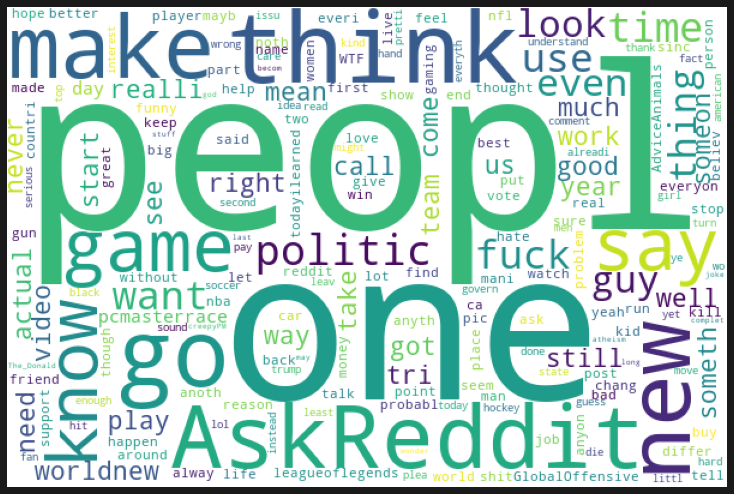

In [121]:
## Wordcloud for Non sarcastic comments
myWordCloudText(1)

In [122]:
X2 = red_copy[['text']]
y2 = red_copy['label']

In [123]:
X_train2, red_test2, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=28)

In [124]:
clean_train2 = parent_vectorizer.fit_transform(X_train2['text'])
clean_test2 = parent_vectorizer.transform(red_test2['text'])

### Naive Bayes

In [125]:
naive_bayes2 = NB.fit(clean_train2, y2_train)

In [126]:
naiveBayes_predict2 = NB.predict(clean_test2)

In [127]:
metrics.accuracy_score(y2_test, naiveBayes_predict2)

0.5658884052235853

### Random forest

In [128]:
random_forest2 = RandomForestClassifier(max_depth=10, max_features=10)
random_forest2.fit(clean_train2, y2_train)

RandomForestClassifier(max_depth=10, max_features=10)

In [129]:
randomForest_predict2 = random_forest2.predict(clean_test2)

In [130]:
metrics.accuracy_score(y2_test, randomForest_predict2)

0.5118717847249703

### Logistic Regression

In [131]:
X2 = red_copy['text']
y2 = red_copy['label']

In [132]:
X_train2, red_test2, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=28)

In [133]:
from sklearn.pipeline import Pipeline
tf_idf2 = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)
# multinomial logistic regression a.k.a softmax classifier
logit = lg(C=1, n_jobs=4, solver='lbfgs', random_state=17, verbose=1)
# sklearn's pipeline
tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf2), 
                                 ('logit', logit)])

In [134]:
tfidf_logit_pipeline.fit(X_train2, y2_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    2.3s finished


Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 2))),
                ('logit',
                 LogisticRegression(C=1, n_jobs=4, random_state=17,
                                    verbose=1))])

In [135]:
roc_auc_score(y2_test, tfidf_logit_pipeline.predict_proba(red_test2)[:,1])

0.5932463940048863

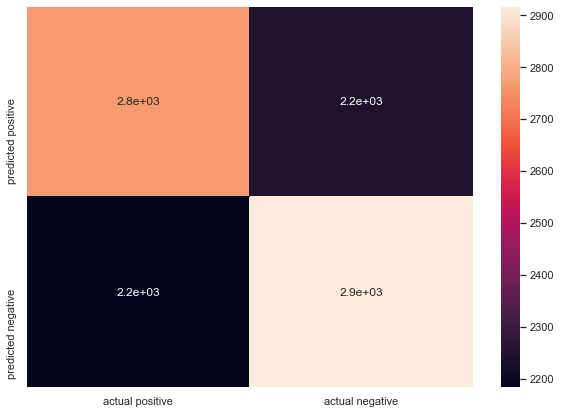

In [136]:
conf_mat2 = pd.DataFrame(confusion_matrix(y2_test, tfidf_logit_pipeline.predict(red_test2)), index = ['predicted positive', 'predicted negative'],
                  columns = ['actual positive', 'actual negative'])
plt.figure(figsize = (10,7))
sns.heatmap(conf_mat2, annot=True)
plt.show()

In [138]:
model = Pipeline([('tfidf',TfidfVectorizer(min_df=2)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
parameters = {'tfidf__ngram_range':[(1,1),(1,2)],'tfidf__use_idf':(True,False)}

### Cross validation and GridSeachCV

#### Naive Bayes

In [162]:
NB_cv2 = cross_val_score(NB, clean_train2, y2_train, n_jobs = -1)
NB_cv2

array([0.56362063, 0.56270096, 0.55713579, 0.56566906, 0.56789513])

#### Random Trees

In [163]:
rf_cv2 = cross_val_score(random_forest2, clean_train2, y_train2, n_jobs = -1)
rf_cv2

array([0.51205639, 0.50692555, 0.51063567, 0.51137769, 0.50890428])

#### Logistic regression with GridSeachCV 

In [139]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=parameters, verbose=2,n_jobs=-1, cv=3, refit=True)

In [140]:
grid.fit(X_train2, y2_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  12 | elapsed:    4.6s remaining:    9.3s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    7.4s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2)),
                                       ('logit',
                                        LogisticRegression(max_iter=3000))]),
             n_jobs=-1,
             param_grid={'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__use_idf': (True, False)},
             verbose=2)

In [141]:
chosen_model = Pipeline([('tfidf',TfidfVectorizer(min_df=2, ngram_range=(1,2),use_idf=True)),
                    ('logit', lg(solver='lbfgs', max_iter=3000))])
chosen_model.fit(X_train2, y2_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(min_df=2, ngram_range=(1, 2))),
                ('logit', LogisticRegression(max_iter=3000))])

In [142]:
from sklearn.metrics import accuracy_score
predictions = chosen_model.predict(red_test2)
print('Accuracy Score: {:.2%}'.format(accuracy_score(y2_test,predictions)),'\n')

Accuracy Score: 56.33% 



## PCA Analysis for dimensionality reduction

https://www.datacamp.com/community/tutorials/categorical-data

In [143]:
category = red_copy['subreddit'].astype('category').cat.categories.tolist()
replace_sub = {'subreddit' : {k: v for k,v in zip(category, list(range(1,len(category)+1)))}}

In [144]:
red_copy.replace(replace_sub, inplace=True)

In [145]:
red_copy.head()

,label,subreddit,parent,char,punct,tokens,clean,text
0,1,2839,"NYT: Donald Trump, Courting Vital Bloc, Is to ...",70,2,12,nyt donald trump court vital bloc speak christ...,nyt donald trump court vital bloc speak christ...
1,1,3209,OKAY REDDIT DONT FUCK THIS TRIPLE DOUBLE UP PL...,50,0,9,okay reddit dont fuck tripl doubl pleas,okay reddit dont fuck tripl doubl pleas nba
2,0,1476,Jammer Meta is blasphemy.,25,1,4,jammer meta blasphemi,jammer meta blasphemi PuzzleAndDragons
3,1,3234,You have no idea. Can't wait for draft day.,43,3,9,idea ca wait draft day,idea ca wait draft day nfl
4,0,1143,They have plenty of forests in the mountains,44,0,8,plenti forest mountain,plenti forest mountain MapPorn


In [146]:
## TF-IDF
vectorizer = TfidfVectorizer(ngram_range=(1,2), min_df=3)
R = vectorizer.fit_transform(red_copy["clean"])
print(R.shape)
type(R)

(50539, 34485)


scipy.sparse.csr.csr_matrix

In [147]:
#L = vectorizer.fit_transform(red_copy["subreddit"])
#print(R.shape)
#type(R)

In [148]:
# We can use hstack to merge two sparse matrices, without having to convert to dense format.
def addFeature(R, feature_to_add):  
    return hstack([R, csr_matrix(feature_to_add).T], 'csr')

In [149]:
R = addFeature(R, red_copy['subreddit'])

In [150]:
print(R.shape)

(50539, 34486)


In [151]:
features = np.append(vectorizer.get_feature_names(), ['Sub'])

In [152]:
features

array(['aa', 'aaa', 'aaa game', ..., 'zulrah', 'zyra', 'Sub'],
      dtype='<U24')

In [153]:
y_label = red_copy['label']

In [154]:
from sklearn.feature_selection import SelectKBest, chi2
selector = SelectKBest(chi2, k=20) 
R_new = selector.fit_transform(R, y_label)
print(R_new.shape)

(50539, 20)


In [155]:
features[selector.get_support()]

array(['black', 'cat', 'climat', 'episod', 'favorit', 'gay', 'govern',
       'law', 'men', 'peopl', 'racist', 'sarcasm', 'sauc', 'smell',
       'thank', 'vaccin', 'white', 'woman', 'women', 'Sub'], dtype='<U24')

In [156]:
# compute chi2 scores for features and sort them from most to less relevant
from sklearn.feature_selection import chi2
stat, pval = chi2(R,y_label)
score = list(zip(features, stat, pval))
score.sort(key = lambda tup: tup[2])
score

[('Sub', 90991.09729318292, 0.0),
 ('thank', 15.053433809459126, 0.00010450994975108889),
 ('peopl', 14.5787337797173, 0.00013442303847722216),
 ('sarcasm', 13.953172049697582, 0.0001874211439820049),
 ('cat', 10.555669017500698, 0.0011583228034120732),
 ('women', 10.282030251942928, 0.0013433205379849858),
 ('men', 9.188736109961653, 0.0024350897578154754),
 ('vaccin', 8.372241965442539, 0.0038099531413696213),
 ('law', 8.033260341180517, 0.004592609769405325),
 ('episod', 7.840706467696619, 0.00510826391179143),
 ('racist', 7.821364414191253, 0.005163220216029791),
 ('govern', 7.431312484678315, 0.006409857430831598),
 ('gay', 7.251063449722001, 0.007085903545569629),
 ('smell', 7.2243330546760545, 0.007192188872061913),
 ('favorit', 7.164723032505044, 0.00743511697287536),
 ('sauc', 7.094828867876834, 0.00773066731772798),
 ('white', 7.017985414977746, 0.00806949717555875),
 ('black', 6.594219148139782, 0.01023104186183899),
 ('climat', 6.475424716928168, 0.010937617370597565),
 ('w

In [157]:
# select features with p-val less than 1%
sel = np.flatnonzero(pval < 0.01)
R_sel = R[:,sel]
features_sel = features[sel]
R_sel

<50539x17 sparse matrix of type '<class 'numpy.float64'>'
	with 58085 stored elements in Compressed Sparse Row format>

In [158]:
# Scale data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
R_scale = scaler.fit_transform(R_sel.toarray())

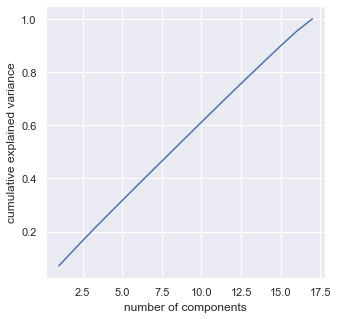

In [159]:
# PCA
from sklearn.decomposition import PCA

pca = PCA().fit(R_scale)
nc  = list(range(1,1+len(pca.explained_variance_ratio_)))
ev  = np.cumsum(pca.explained_variance_ratio_)
plt.plot(nc, ev)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()